In [1]:
%load_ext autoreload
%autoreload 2

# BUG-Algorithm for a Simple Open Quantum System

We simulate a TFI model
$$
H = \sum_{i=1}^{L-1} X_iX_{i+1} + \sum_{i=1}^L Z_i
$$
with local relaxation $\sigma^-_i$ and dephasing $Z_i$.

## Exact Solution

In [2]:
from typing import Iterator
from itertools import chain

from numpy import ndarray

from pytreenet.operators.exact_operators import (exact_ising_hamiltonian,
                                                 exact_lindbladian,
                                                 exact_local_magnetisation,
                                                 exact_single_site_operator,
                                                 exact_zero_state,
                                                 exact_state_to_density_matrix)
from pytreenet.operators.common_operators import (bosonic_operators,
                                                  pauli_matrices)
from pytreenet.time_evolution.exact_time_evolution import (ExactTimeEvolution,
                                                           ExactTimeEvolutionConfig)

In [3]:
def exact_initial_state(length: int) -> ndarray:
    """
    Returns the exact initial state for the open quantum Ising model.

    Args:
        length (int): The length of the chain.

    Returns:
        ndarray: The initial state.
    
    """
    state = exact_zero_state(length, 2)
    state = exact_state_to_density_matrix(state,
                                          vectorise=True)
    return state

def exact_operators(length: int,
                    hamiltonian: ndarray | None = None
                    ) -> dict[str, ndarray]:
    """
    Returns the exact operators to be evaluated.
    Args:
        length (int): The length of the chain.
        hamiltonian (ndarray | None): The Hamiltonian of the system should
            be provided if the energy is to be evaluated.

    Returns:
        ndarray: The operators.
    
    """
    ids = [f"qubit{i}" for i in range(length)]
    operators = exact_local_magnetisation(ids)
    if hamiltonian is not None:
        operators["energy"] = hamiltonian
    return operators

def exact_relaxation_operators(length: int,
                              relaxation_rate: float
                                ) -> Iterator[ndarray]:
    """
    Returns the relaxation operator for the open quantum Ising model.

    Args:
        length (int): The length of the chain.
        relaxation_rate (float): The relaxation rate.
    
    Returns:
        Iterator: The relaxation operators.
    
    """
    relaxation_op = bosonic_operators(dimension=2)[1]
    for i in range(length):
        loc_op = exact_single_site_operator(relaxation_op, i, length)
        yield relaxation_rate * loc_op

def exact_dephasing_operators(length: int,
                              dephasing_rate: float
                                ) -> Iterator[ndarray]:
    """
    Returns the dephasing operator for the open quantum Ising model.

    Args:
        length (int): The length of the chain.
        dephasing_rate (float): The dephasing rate.
    
    Returns:
        Iterator: The dephasing operators.
    
    """
    dephasing_op = pauli_matrices()[2]
    for i in range(length):
        loc_op = exact_single_site_operator(dephasing_op, i, length)
        yield dephasing_rate * loc_op

def exact_ising_lindbladian(length: int,
                            ext_magn: float,
                            coupling: float,
                            relaxation_rate: float,
                            dephasing_rate: float
                            ) -> ndarray:
    """
    Returns the exact Lindbladian for the open quantum Ising model.

    Args:
        length (int): The length of the chain.
        ext_magn (float): The external magnetic field.
        coupling (float): The coupling constant.
        relaxation_rate (float): The relaxation rate.
        dephasing_rate (float): The dephasing rate.

    Returns:
        ndarray: The Lindbladian.
    
    """
    ham = exact_ising_hamiltonian(coupling, ext_magn, length)
    # Relaxation Ops
    relaxation_ops = exact_relaxation_operators(length,
                                                relaxation_rate)
    # Dephasing Ops
    dephasing_ops = exact_dephasing_operators(length,
                                              dephasing_rate)
    jump_ops = chain(relaxation_ops, dephasing_ops)
    lindbladian = exact_lindbladian(ham, jump_ops)
    return lindbladian

In [4]:
min_length = 2
max_length = 5
ext_magn = 0.5
coupling = 1.0
relaxation_rate = 0.1
dephasing_rate = 0.1
time_step_size = 0.01
final_time = 1

In [5]:
exact_results = []
for length in range(min_length,max_length+1):
    lindbladian = exact_ising_lindbladian(length,
                                          ext_magn,
                                          coupling,
                                          relaxation_rate,
                                          dephasing_rate
                                          )
    initial_state = exact_initial_state(length)
    operators = exact_operators(length)
    config = ExactTimeEvolutionConfig(open=True)
    time_evolution = ExactTimeEvolution(initial_state,
                                        lindbladian,
                                        time_step_size,
                                        final_time,
                                        operators,
                                        config)
    time_evolution.run()
    ids = [f"qubit{i}" for i in range(length)]
    run_res = {}
    for qubit in ids:
        run_res[qubit] = time_evolution.operator_result(qubit, realise=True)
    run_res["times"] = time_evolution.times()
    exact_results.append(run_res)
del time_evolution
del lindbladian
del initial_state
del operators


100%|██████████| 101/101 [00:00<00:00, 2154.90it/s]


## Tree Tensor Network Simulation

In [6]:
from fractions import Fraction

from numpy import ndarray, zeros

from pytreenet.special_ttn.binary import generate_binary_ttns
from pytreenet.ttns.ttndo import (SymmetricTTNDO,
                                  from_ttns)
from pytreenet.operators.models import (ising_model,
                                        flipped_ising_model,
                                        local_magnetisation,)
from pytreenet.operators.sim_operators import single_site_operators
from pytreenet.operators.common_operators import pauli_matrices, ket_i
from pytreenet.operators.tensorproduct import TensorProduct
from pytreenet.operators.lindbladian import generate_lindbladian
from pytreenet.ttno.ttno_class import TreeTensorNetworkOperator
from pytreenet.operators.hamiltonian import Hamiltonian
from pytreenet.ttns.ttns import TreeTensorNetworkState

In [7]:
max_bond_dim = 10
rel_tol = 1e-6
total_tol = 1e-6

In [8]:
def binary_ttndo(length: int,
                 local_state: ndarray
                 ) -> tuple[SymmetricTTNDO, TreeTensorNetworkState]:
    """
    Generates a binaray TTNDO of the desired length.

    Args:
        length (int): The length of the TTNDO.
        local_state (ndarray): The local state of the TTNDO.
    
    Returns:
        SymmetricTTNDO: The binary TTNDO.
    """
    phys_dim = 2
    assert local_state.shape == (phys_dim, )
    bond_dim = 2
    phys_tensor = zeros((bond_dim,phys_dim),
                        dtype=complex)
    phys_tensor[0,:] = local_state
    ttns = generate_binary_ttns(length,
                                bond_dim,
                                phys_tensor,
                                "qubit")
    ttndo = from_ttns(ttns,
                      root_bond_dim=bond_dim)
    return ttndo, ttns

def phys_node_identifiers(length: int) -> list[str]:
    """
    Generates the node identifiers for the physical nodes.

    Args:
        length (int): The length of the system.
    
    Returns:
        list[str]: The node identifiers.
    """
    return [f"qubit{i}" for i in range(length)]

def jump_operators(length: int,
                   relaxation_rate: float,
                   dephasing_rate:float
                   ) -> tuple[list[tuple[Fraction,str,TensorProduct]], dict[str,ndarray], dict[str,complex]]:
    """
    Generates the jump operators for the open Ising model.

    Args:
        length (int): The length of the system.
        relaxation_rate (float): The relaxation rate.
        dephasing_rate (float): The dephasing rate.

    Returns:
        list[tuple[Fraction,str,TensorProduct]]: The jump operator terms.
        dict[str,ndarray]: The jump operator conversion dictionary.
        dict[str,float]: The jump operator coefficient mapping
    
    """
    node_identifiers = phys_node_identifiers(length)
    # Create relaxation jump operators
    rel_fac_name = "relaxation_rate"
    factor = (Fraction(1), rel_fac_name)
    relax_name = "sigma_-"
    relaxation_ops = single_site_operators(relax_name,
                                           node_identifiers,
                                           factor)
    # Create dephasing jump operators
    deph_fac_name = "dephasing_rate"
    factor = (Fraction(1), deph_fac_name)
    deph_name = "Z"
    dephasing_ops = single_site_operators(deph_name,
                                          node_identifiers,
                                          factor)
    # Combine the jump operators
    jump_ops = list(relaxation_ops.values())
    jump_ops.extend(list(dephasing_ops.values()))
    # Create the jump operator matrix mapping
    conversion_dict = {relax_name: bosonic_operators()[1],
                       deph_name: pauli_matrices()[2]}
    # Create the jump operator coefficient mapping
    coeff_dict = {rel_fac_name: complex(relaxation_rate),
                  deph_fac_name: complex(dephasing_rate)}
    return jump_ops, conversion_dict, coeff_dict

def open_ising_model_ttno(length: int,
                          ttndo: SymmetricTTNDO,
                          ext_magn: float,
                          coupling: float,
                          relaxation_rate: float,
                          dephasing_rate: float,
                          flipped: bool = False
                          ) -> tuple[TreeTensorNetworkOperator, Hamiltonian]:
    """
    Generates the Hamiltonian for the open Ising model.

    Additionally to the usual TFI model two jump operators act on every site
    separately. The first jump operator is relaxation and the second is 
    dephasing.

    Args:
        length (int): The length of the system.
        ttndo (SymmetricTTNDO): The TTNDO of the system.
        ext_magn (float): The external magnetic field.
        coupling (float): The coupling strength.
        relaxation_rate (float): The relaxation rate.
        dephasing_rate (float): The dephasing rate.
        flipped (bool): Whether to use the flipped Ising model.

    Returns:
        TreeTensorNetworkOperator: The TTNO.
    
    """
    node_identifiers = phys_node_identifiers(length)
    nn_pairs = [(node_identifiers[i], node_identifiers[i+1])
                for i in range(length-1)]
    if flipped:
        ham = flipped_ising_model(nn_pairs,
                                  ext_magn,
                                  factor=coupling)
    else:
        ham = ising_model(nn_pairs,
                          ext_magn,
                          factor=coupling)
    jump_ops, conversion_dict, coeff_dict = jump_operators(length,
                                                          relaxation_rate,
                                                          dephasing_rate)
    lindbladian = generate_lindbladian(ham,
                                        jump_ops,
                                        conversion_dict,
                                        coeff_dict)
    ttno = TreeTensorNetworkOperator.from_hamiltonian(lindbladian,
                                                      ttndo)
    return ttno, ham

def open_ising_operators(length: int,
                         ttns: TreeTensorNetworkState,
                         ising_ham: Hamiltonian
                         ) -> dict:
    """
    Generates the operators to be evaluated for the open Ising model.
    
    Args:
        length (int): The length of the system.
        ttns (TreeTensorNetworkState): The TTN state of the system.
        ising_ham (Hamiltonian): The Ising Hamiltonian.
    
    Returns:
        dict: The operators.

    """
    node_identifiers = phys_node_identifiers(length)
    ops = {key: tup[2]
           for key, tup in local_magnetisation(node_identifiers).items()}
    ttno = TreeTensorNetworkOperator.from_hamiltonian(ising_ham,
                                                      ttns)
    ops["energy"] = ttno
    return ops

### BUG Simulation

In [9]:
from pytreenet.time_evolution.bug import BUG, BUGConfig

In [10]:
bug_results = []
for length in range(min_length,max_length+1):
    ttndo, ttns = binary_ttndo(length, ket_i(0,2))
    ttno, ising_ham = open_ising_model_ttno(length,
                                            ttndo,
                                            ext_magn,
                                            coupling,
                                            relaxation_rate,
                                            dephasing_rate)
    operators = open_ising_operators(length,
                                     ttns,
                                     ising_ham)
    config = BUGConfig(max_bond_dim=max_bond_dim,
                       rel_tol=rel_tol,
                       total_tol=total_tol)
    bug = BUG(ttndo,
              ttno,
              time_step_size,
              final_time,
              operators,
              config=config)
    bug.run()
    ids = [f"qubit{i}" for i in range(length)]
    run_res = {}
    for qubit in ids:
        run_res[qubit] = bug.operator_result(qubit, realise=True)
    run_res["times"] = bug.times()
    bug_results.append(run_res)
del bug
del ttno
del ttndo
    

100%|██████████| 101/101 [00:08<00:00, 11.99it/s]


### TDVP Simulation

In [11]:
from pytreenet.time_evolution.tdvp_algorithms.secondordertwosite import SecondOrderTwoSiteTDVP
from pytreenet.util.tensor_splitting import SVDParameters

In [12]:
tdvp_results = []
for length in range(min_length, max_length+1):
    ttndo, ttns = binary_ttndo(length, ket_i(0,2))
    ttno, ising_ham = open_ising_model_ttno(length,
                                            ttndo,
                                            ext_magn,
                                            coupling,
                                            relaxation_rate,
                                            dephasing_rate)
    operators = open_ising_operators(length,
                                     ttns,
                                     ising_ham)
    svd_params = SVDParameters(max_bond_dim=max_bond_dim,
                               rel_tol=rel_tol,
                               total_tol=total_tol)
    tdvp = SecondOrderTwoSiteTDVP(ttndo,
                                  ttno,
                                  time_step_size,
                                  final_time,
                                  operators,
                                  svd_params)
    tdvp.run()
    ids = [f"qubit{i}" for i in range(length)]
    run_res = {}
    for qubit in ids:
        run_res[qubit] = tdvp.operator_result(qubit, realise=True)
    run_res["times"] = tdvp.times()
    tdvp_results.append(run_res)
del tdvp
del ttno
del ttndo

100%|██████████| 101/101 [00:05<00:00, 17.26it/s]


## Plotting

In [13]:
import matplotlib.pyplot as plt

In [14]:
bug_errors = []
tdvp_errors = []
for i, exact_result in enumerate(exact_results):
    bug_result = bug_results[i]
    tdvp_result = tdvp_results[i]
    bug_error = {}
    tdvp_error = {}
    for key in exact_result.keys():
        if key == "times":
            bug_error[key] = bug_result[key]
            tdvp_error[key] = tdvp_result[key]
        else:
            bug_error[key] = abs(exact_result[key] - bug_result[key])
            tdvp_error[key] = abs(exact_result[key] - tdvp_result[key])
    bug_errors.append(bug_error)
    tdvp_errors.append(tdvp_error)

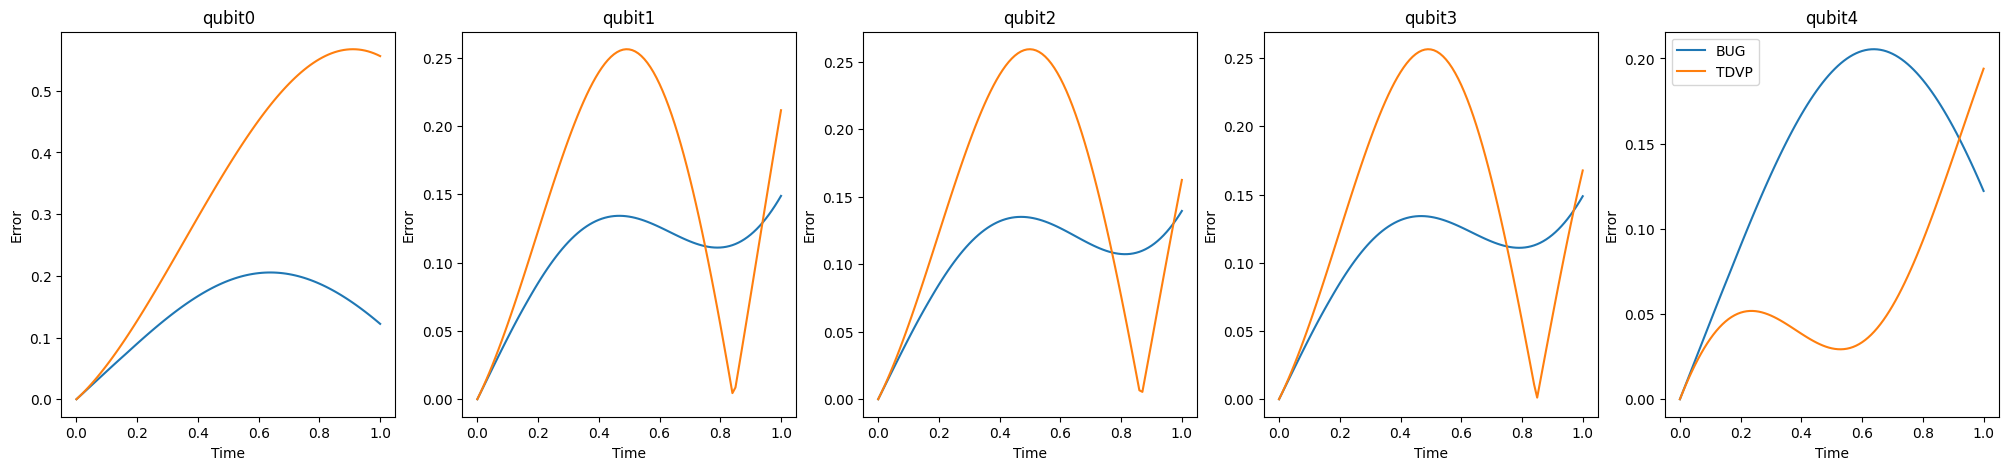

In [15]:
figure, axs = plt.subplots(1, max_length, figsize=(25,5))
length_index = -1
times = exact_results[length_index]["times"]
for i, qubit in enumerate(bug_errors[length_index].keys()):
    if qubit != "times":
        axs[i].plot(times, bug_errors[length_index][qubit], label="BUG")
        axs[i].plot(times, tdvp_errors[length_index][qubit], label="TDVP")
        axs[i].set_title(qubit)
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel("Error")
plt.legend()
plt.show()